# Cancer Classification

## 1. Overview

- 갑상선 초음파 사진을 이용하여 딥러닝 모델을 학습 시킨 후 종양(tumor)이 양성(benign)인지, 악성(malignant)인지 구분해 본다.
- 다양한 모델을 학습시킨 후 accuracy를 비교한다.
- 총 5가지 모델(EfficientNetB7, VGG16, VGG19, ResNet50, ResNet101)을 사용

## 2 - 1 . Dataset - normal
- TRAIN 폴더 안에 Benign, Cancer 폴더가 있으며 각각 9004개 이미지, 2389개의 이미지가 있다.
- TEST 폴더 안에 Benign, Cancer 폴더가 있으며 각각 899개 이미지, 267개의 이미지가 있다.
- 각 이미지의 파일명은 (B_001-0002-1.0.jpg) 와 같이 맨 앞에 B, M으로 labelling 되어 있으며 그 뒤는 숫자로 이루어져 있다.
- 모든 파일은 .jpg 형식이다.

## 2 - 2 . Dataset - cropped
- cropped된 이미지 파일
- normal dataset의 종양 부분만 잘라서 만든 이미지
- Train2 폴더 안에 Benign, Cancer 폴더가 있으며 각각 7324개 이미지, 1624개의 이미지가 있다.
- Test2 폴더 안에 Benign, Cancer 폴더가 있으며 각각 1831개 이미지, 406개의 이미지가 있다.
- 각 이미지의 파일명은 (B_001-0002-1.0.jpg) 와 같이 맨 앞에 B, M으로 labelling 되어 있으며 그 뒤는 숫자로 이루어져 있다.
- 모든 파일은 .jpg 형식이다.

## 3. 라이브러리 불러오기

In [1]:
import tensorflow as tf
import numpy as np

import pandas as pd
import cv2
import os
import math
import scipy as sp
import PIL

# Tensorflow
from tensorflow.keras import models, layers, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, ZeroPadding2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB6, ResNet50V2
#from keras_tuner.tuners import RandomSearch

import scikitplot as skplt
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from ipywidgets import interact

## 4. 이미지 파일 경로 불러오기

In [2]:
for file_path in os.listdir('./TRAIN'):
    print(file_path)

Benign
Cancer


In [3]:

image_format = ['jpeg','jpg','png'] # 이미지 포맷이 다양할 경우

def list_image_files(data_dir, sub_dir):
    image_files=[]
    images_dir=os.path.join(data_dir, sub_dir) # data_dir, sub_dir 이거랑 경로 연결
    for file_path in os.listdir(images_dir):
        if file_path.split('.')[-1] in image_format:
            image_files.append(os.path.join(sub_dir, file_path))
    return image_files

In [4]:
data_dir = './TRAIN/'

benign_list=list_image_files(data_dir, 'Benign')
cancer_list=list_image_files(data_dir, 'Cancer')


print(f'Benign:{len(benign_list)}, Cancer:{len(cancer_list)}')

Benign:9004, Cancer:2389


## 5. 이미지 데이터 확인하기

In [5]:
# 경로 합친 다음 BGR을 RGB로 바꿔서 이미지 불러오기
def get_RGB_image(data_dir, file_name):
    image_file = os.path.join(data_dir, file_name)
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [6]:
min_num_files = min(len(benign_list), len(cancer_list))
print(min_num_files) # 갯수 맞추려고 제일 적은 개수 찾음

2389


In [7]:
@interact(index=(0, min_num_files-1)) # 0부터 69까지 슬라이드 바 생성 
def show_samples(index=0):
    benign_image = get_RGB_image(data_dir, benign_list[index])
    cancer_image = get_RGB_image(data_dir, cancer_list[index])
    
    plt.figure(figsize=(12,8))
    plt.subplot(121)
    plt.title('Benign')
    plt.imshow(benign_image)
    
    plt.subplot(122)
    plt.title('Cancer')
    plt.imshow(cancer_image)

interactive(children=(IntSlider(value=0, description='index', max=2388), Output()), _dom_classes=('widget-inte…

In [8]:
data_dir = './Train2/'

benign_list=list_image_files(data_dir, 'Benign')
cancer_list=list_image_files(data_dir, 'Cancer')


print(f'Benign:{len(benign_list)}, Cancer:{len(cancer_list)}')

Benign:7324, Cancer:1624


In [9]:
min_num_files = min(len(benign_list), len(cancer_list))
print(min_num_files) # 갯수 맞추려고 제일 적은 개수 찾음

1624


In [10]:
@interact(index=(0, min_num_files-1)) # 0부터 69까지 슬라이드 바 생성 
def show_samples(index=0):
    benign_image = get_RGB_image(data_dir, benign_list[index])
    cancer_image = get_RGB_image(data_dir, cancer_list[index])
    
    plt.figure(figsize=(12,8))
    plt.subplot(121)
    plt.title('Benign')
    plt.imshow(benign_image)
    
    plt.subplot(122)
    plt.title('Cancer')
    plt.imshow(cancer_image)

interactive(children=(IntSlider(value=0, description='index', max=1623), Output()), _dom_classes=('widget-inte…

이미지를 비교하며 확인했을 때 전문가가 아닌 이상 어느 것이 양성이고, 악성인지 알기 어렵다.

## 6. 이미지 데이터 학습하기

In [9]:
# 디렉토리 경로 설정
CurrentDirectory = "./"

train_directory = CurrentDirectory + 'TRAIN/'
test_directory  = CurrentDirectory + 'TEST/'
model_directory = CurrentDirectory + 'MODEL/'
tensorboard_directory = CurrentDirectory + 'Tensorboard'

In [10]:
# 모델 학습을 위한 설정
# batch_size: 한번에 forward & Backword 하는 샘플의 수
batch_size = 32

# Training 수
# epochs = 50

# Weight 조절 parameter
LearningRate = 1e-3 # 0.001
Decay = 1e-6

img_width = 224
img_height = 224

## 6 - 1. 모델 선택

In [11]:
# model_select = ['EfficientNetB7', 'VGG16', 'VGG19', 'ResNet50', 'ResNet101']
model_select = 'EfficientNetB7'

In [21]:
# EfficientNetB7
EfficientNetB7Model = tf.keras.applications.EfficientNetB7(include_top=False, weights='imagenet', input_tensor=None, input_shape=(img_width,img_height,3), pooling=None)
x = GlobalAveragePooling2D()(EfficientNetB7Model.output)
predictions = Dense(2, activation='softmax')(x)

DeepLearning_EfficientNetB7 = Model(inputs=EfficientNetB7Model.input, outputs=predictions)

DeepLearning_EfficientNetB7.compile(optimizer=
         SGD(lr=LearningRate, decay=Decay, momentum=0.9, nesterov=True), 
         loss='categorical_crossentropy',
         metrics=['acc']
)

# VGG16
VGG16Model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(img_width,img_height,3), pooling=None)
x = GlobalAveragePooling2D()(VGG16Model.output)
predictions = Dense(2, activation='softmax')(x)

DeepLearning_VGG16 = Model(inputs=VGG16Model.input, outputs=predictions)


DeepLearning_VGG16.compile(optimizer=
         SGD(lr=LearningRate, decay=Decay, momentum=0.9, nesterov=True), 
         loss='categorical_crossentropy',
         metrics=['acc']
)

# VGG19
VGG19Model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_tensor=None, input_shape=(img_width,img_height,3), pooling=None)
x = GlobalAveragePooling2D()(VGG19Model.output)
predictions = Dense(2, activation='softmax')(x)

DeepLearning_VGG19 = Model(inputs=VGG19Model.input, outputs=predictions)

DeepLearning_VGG19.compile(optimizer=
         SGD(lr=LearningRate, decay=Decay, momentum=0.9, nesterov=True), 
         loss='categorical_crossentropy',
         metrics=['acc']
)

# ResNet50
ResNet50Model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=(img_width,img_height,3), pooling=None)
x = GlobalAveragePooling2D()(ResNet50Model.output)
predictions = Dense(2, activation='softmax')(x)

DeepLearning_ResNet50 = Model(inputs=ResNet50Model.input, outputs=predictions)


DeepLearning_ResNet50.compile(optimizer=
         SGD(lr=LearningRate, decay=Decay, momentum=0.9, nesterov=True), 
         loss='categorical_crossentropy',
         metrics=['acc']
)

# ResNet101
ResNet101Model = tf.keras.applications.ResNet101(include_top=False, weights='imagenet', input_tensor=None, input_shape=(img_width,img_height,3), pooling=None)
x = GlobalAveragePooling2D()(ResNet101Model.output)
predictions = Dense(2, activation='softmax')(x)

DeepLearning_ResNet101 = Model(inputs=ResNet101Model.input, outputs=predictions)

DeepLearning_ResNet101.compile(optimizer=
         SGD(lr=LearningRate, decay=Decay, momentum=0.9, nesterov=True), 
         loss='categorical_crossentropy',
         metrics=['acc']
)

C:\Users\USER\miniforge3\envs\dl2\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


## 6 - 2. generator 설정

In [13]:
# Online-augmentation 적용 Generator
# 1. 이미지를 전부다 불러서 램 (메모리)에 올릴 수 없기 때문
# 2. 이미지는 Augmentation을 해주는게 좋아서

DATAGEN_TRAIN = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last",
    validation_split=0.10) # Train / Validation

# Online-augmentation 비적용 Generator (Test용)
DATAGEN_TEST = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last")

In [14]:
# Generator의 instance 생성 (Train)
TRAIN_GENERATOR = DATAGEN_TRAIN.flow_from_directory(
    train_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode= "categorical",
    subset = "training")

VALID_GENERATOR = DATAGEN_TRAIN.flow_from_directory(
    train_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode= "categorical",
    subset = "validation")

# Generator의 instance 생성 (Test)
TEST_GENERATOR = DATAGEN_TEST.flow_from_directory(
    test_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = False,
    class_mode= "categorical")

Found 10255 images belonging to 2 classes.
Found 1138 images belonging to 2 classes.
Found 1166 images belonging to 2 classes.


## 6 - 3. call-back 함수 설정

In [15]:

# Call-back 함수

# CheckPoint: Epoch 마다 validation 성능을 검증하여, best performance 일 경우 저장

CP_EfficientNetB7 = ModelCheckpoint(filepath=model_directory+'EfficientNetB7-{epoch:03d}-{val_loss:.4f}-{val_acc:.4f}.hdf5',
        monitor='val_acc', verbose=1, save_best_only=True, mode='max')


CP_VGG16 = ModelCheckpoint(filepath=model_directory+'VGG16-{epoch:03d}-{val_loss:.4f}-{val_acc:.4f}.hdf5',
        monitor='val_acc', verbose=1, save_best_only=True, mode='max')


CP_VGG19 = ModelCheckpoint(filepath=model_directory+'VGG19-{epoch:03d}-{val_loss:.4f}-{val_acc:.4f}.hdf5',
        monitor='val_acc', verbose=1, save_best_only=True, mode='max')


CP_ResNet50 = ModelCheckpoint(filepath=model_directory+'ResNet50-{epoch:03d}-{val_loss:.4f}-{val_acc:.4f}.hdf5',
        monitor='val_acc', verbose=1, save_best_only=True, mode='max')


CP_ResNet101 = ModelCheckpoint(filepath=model_directory+'ResNet101-{epoch:03d}-{val_loss:.4f}-{val_acc:.4f}.hdf5',
        monitor='val_acc', verbose=1, save_best_only=True, mode='max')

    

# 학습과정 진행사항 확인
TB = TensorBoard(log_dir=tensorboard_directory, write_graph=True, write_images=True)

# Learning Rate 줄여나가기
LR = ReduceLROnPlateau(monitor='val_loss',factor=0.8,patience=3, verbose=1, min_lr=1e-8)

CALLBACK_EfficientNetB7 = [CP_EfficientNetB7, TB, LR]
CALLBACK_VGG16 = [CP_VGG16, TB, LR]
CALLBACK_VGG19 = [CP_VGG19, TB, LR]
CALLBACK_ResNet50 = [CP_ResNet50, TB, LR]
CALLBACK_ResNet101 = [CP_ResNet101, TB, LR]

## 6 - 4. 모델 학습

In [ ]:
# DeepLearning_EfficientNetB7
DeepLearning_EfficientNetB7.fit(
    TRAIN_GENERATOR,
    epochs=15,
    callbacks=CALLBACK_EfficientNetB7,
    shuffle=True, 
    validation_data=VALID_GENERATOR)


In [ ]:
# DeepLearning_VGG16
DeepLearning_VGG16.fit(
    TRAIN_GENERATOR,
    epochs=15,
    callbacks=CALLBACK_VGG16,
    shuffle=True,
    validation_data=VALID_GENERATOR)

In [ ]:
# DeepLearning_VGG19
DeepLearning_VGG19.fit(
    TRAIN_GENERATOR,
    epochs=15,
    callbacks=CALLBACK_VGG19,
    shuffle=True,
    validation_data=VALID_GENERATOR)

In [ ]:
# DeepLearning_ResNet50
DeepLearning_ResNet50.fit(
    TRAIN_GENERATOR,
    epochs=15,
    callbacks=CALLBACK_ResNet50,
    shuffle=True,
    validation_data=VALID_GENERATOR)

In [ ]:
# DeepLearning_ResNet101
DeepLearning_ResNet101.fit(
    TRAIN_GENERATOR,
    epochs=15,
    callbacks=CALLBACK_ResNet101,
    shuffle=True, 
    validation_data=VALID_GENERATOR)

## 7. 학습 결과 확인

In [16]:
# 학습이 끝난 후 학습된 hdf5 파일을 리스트에 넣어준다.
EfficientNetB7_hdf5 =[]
VGG16_hdf5 =[]
VGG19_hdf5 =[]
ResNet50_hdf5 =[]
ResNet101_hdf5 =[]
for file_path in os.listdir(model_directory):
    if file_path.split('-')[0] == 'EfficientNetB7':
        EfficientNetB7_hdf5.append(file_path)
    elif file_path.split('-')[0] == 'VGG16':
        VGG16_hdf5.append(file_path)
    elif file_path.split('-')[0] == 'VGG19':
        VGG19_hdf5.append(file_path)
    elif file_path.split('-')[0] == 'ResNet50':
        ResNet50_hdf5.append(file_path)
    elif file_path.split('-')[0] == 'ResNet101':
        ResNet101_hdf5.append(file_path)

In [18]:
# 리스트에 있는 파일 중 가장 뒤에 있는 파일을 불러와서 모델에 적용한다.

DeepLearning_EfficientNetB7.load_weights(model_directory+EfficientNetB7_hdf5[-1])

DeepLearning_VGG16.load_weights(model_directory+VGG16_hdf5[-1])

DeepLearning_VGG19.load_weights(model_directory+VGG19_hdf5[-1])

DeepLearning_ResNet50.load_weights(model_directory+ResNet50_hdf5[-1])

DeepLearning_ResNet101.load_weights(model_directory+ResNet101_hdf5[-1])

### call-back 
- EfficientNetB7-001-0.5327-0.7909.hdf5
- VGG16-012-0.4714-0.8155.hdf5
- VGG19-010-0.4609-0.8172.hdf5
- ResNet50-005-0.5210-0.8181.hdf5
- ResNet101-005-0.5002-0.8251.hdf5

In [19]:
# Prediction
TEST_Prediction_EfficientNetB7 = DeepLearning_EfficientNetB7.predict_generator(TEST_GENERATOR, verbose=1)
TEST_Prediction_VGG16 = DeepLearning_VGG16.predict_generator(TEST_GENERATOR, verbose=1)
TEST_Prediction_VGG19 = DeepLearning_VGG19.predict_generator(TEST_GENERATOR, verbose=1)
TEST_Prediction_ResNet50 = DeepLearning_ResNet50.predict_generator(TEST_GENERATOR, verbose=1)
TEST_Prediction_ResNet101 = DeepLearning_ResNet101.predict_generator(TEST_GENERATOR, verbose=1)

C:\Users\USER\AppData\Local\Temp\ipykernel_8704\4177169053.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  TEST_Prediction_EfficientNetB7 = DeepLearning_EfficientNetB7.predict_generator(TEST_GENERATOR, verbose=1)
C:\Users\USER\miniforge3\envs\dl2\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\USER\miniforge3\envs\dl2\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


37/37 [==============================] - 481s 13s/step


C:\Users\USER\AppData\Local\Temp\ipykernel_8704\4177169053.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  TEST_Prediction_VGG16 = DeepLearning_VGG16.predict_generator(TEST_GENERATOR, verbose=1)


37/37 [==============================] - 235s 6s/step


C:\Users\USER\AppData\Local\Temp\ipykernel_8704\4177169053.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  TEST_Prediction_VGG19 = DeepLearning_VGG19.predict_generator(TEST_GENERATOR, verbose=1)


37/37 [==============================] - 328s 9s/step


C:\Users\USER\AppData\Local\Temp\ipykernel_8704\4177169053.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  TEST_Prediction_ResNet50 = DeepLearning_ResNet50.predict_generator(TEST_GENERATOR, verbose=1)


37/37 [==============================] - 131s 4s/step


C:\Users\USER\AppData\Local\Temp\ipykernel_8704\4177169053.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  TEST_Prediction_ResNet101 = DeepLearning_ResNet101.predict_generator(TEST_GENERATOR, verbose=1)


37/37 [==============================] - 233s 6s/step


In [20]:
# data frame으로 변환
Result_EfficientNetB7 = pd.DataFrame(TEST_Prediction_EfficientNetB7)
Result_VGG16 = pd.DataFrame(TEST_Prediction_VGG16)
Result_VGG19 = pd.DataFrame(TEST_Prediction_VGG19)
Result_ResNet50 = pd.DataFrame(TEST_Prediction_ResNet50)
Result_ResNet101 = pd.DataFrame(TEST_Prediction_ResNet101)

<AxesSubplot:title={'center':'Result_ResNet101'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

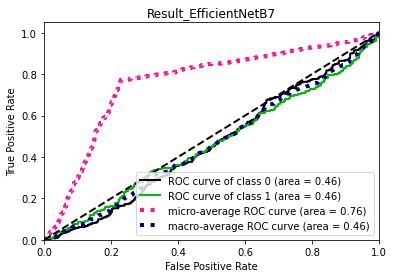

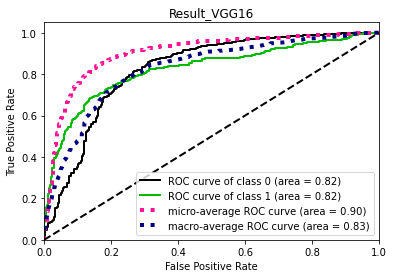

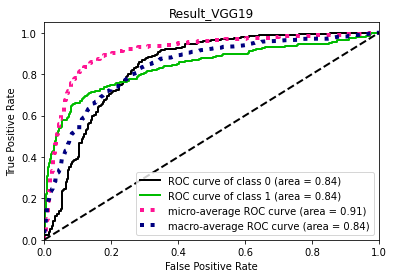

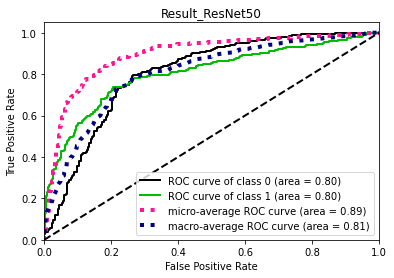

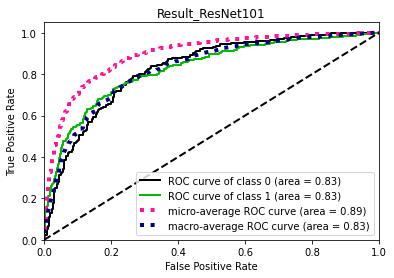

In [41]:
skplt.metrics.plot_roc(TEST_GENERATOR.classes.tolist(), Result_EfficientNetB7, title='Result_EfficientNetB7')

skplt.metrics.plot_roc(TEST_GENERATOR.classes.tolist(), Result_VGG16, title='Result_VGG16')

skplt.metrics.plot_roc(TEST_GENERATOR.classes.tolist(), Result_VGG19, title='Result_VGG19')

skplt.metrics.plot_roc(TEST_GENERATOR.classes.tolist(), Result_ResNet50, title='Result_ResNet50')

skplt.metrics.plot_roc(TEST_GENERATOR.classes.tolist(), Result_ResNet101, title='Result_ResNet101')

## 8. 학습 결과 종합

결과를 확인해보면 EfficientNetB7을 제외한 다른 모델은 80%이상의 확률로 classification을 하였다.

처음에는 EfficientNetB7이 가장 좋은 모델이라고 해서 당연히 좋게 나올 줄 알았으나, 

의외로 제대로 학습이 되지 않았고 이전 모델인 VGG, ResNet이 좋은 결과를 보여주었다.

VGG19 > ResNet101 > VGG16 > ResNet50 순서로 좋은 결과가 나왔는데,

https://keras.io/api/applications/

keras document에 나와있는 값과는 조금 다른 결과를 보인다.

어떤 data를 사용하는지, 어떤 모델을 선택하는지가 예측에 큰 영향을 준다는 것을 알 수 있는 결과였다.

## 9. Cropped된 data로 학습 후 Cropped된 data로 결과 확인하기

Cropped된 data로 학습 >> Cropped된 data로 test

학습 과정 생략

In [35]:
for file_path in os.listdir('./Train2'):
    print(file_path)

Benign
Cancer


In [36]:

image_format = ['jpeg','jpg','png'] # 이미지 포맷이 다양할 경우

def list_image_files(data_dir, sub_dir):
    image_files=[]
    images_dir=os.path.join(data_dir, sub_dir) # data_dir, sub_dir 이거랑 경로 연결
    for file_path in os.listdir(images_dir):
        if file_path.split('.')[-1] in image_format:
            image_files.append(os.path.join(sub_dir, file_path))
    return image_files

In [37]:
data_dir = './Train2/'

benign_list=list_image_files(data_dir, 'Benign')
cancer_list=list_image_files(data_dir, 'Cancer')


print(f'Benign:{len(benign_list)}, Cancer:{len(cancer_list)}')

Benign:7324, Cancer:1624


In [38]:
# 경로 합친 다음 BGR을 RGB로 바꿔서 이미지 불러오기
def get_RGB_image(data_dir, file_name):
    image_file = os.path.join(data_dir, file_name)
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [39]:
min_num_files = min(len(benign_list), len(cancer_list))
print(min_num_files) # 갯수 맞추려고 제일 적은 개수 찾음

1624


In [40]:
@interact(index=(0, min_num_files-1)) # 0부터 69까지 슬라이드 바 생성 
def show_samples(index=0):
    benign_image = get_RGB_image(data_dir, benign_list[index])
    cancer_image = get_RGB_image(data_dir, cancer_list[index])
    
    plt.figure(figsize=(12,8))
    plt.subplot(121)
    plt.title('Benign')
    plt.imshow(benign_image)
    
    plt.subplot(122)
    plt.title('Cancer')
    plt.imshow(cancer_image)

interactive(children=(IntSlider(value=0, description='index', max=1623), Output()), _dom_classes=('widget-inte…

In [8]:
data_dir = './Train2/'

benign_list=list_image_files(data_dir, 'Benign')
cancer_list=list_image_files(data_dir, 'Cancer')


print(f'Benign:{len(benign_list)}, Cancer:{len(cancer_list)}')

Benign:7324, Cancer:1624


In [9]:
min_num_files = min(len(benign_list), len(cancer_list))
print(min_num_files) # 갯수 맞추려고 제일 적은 개수 찾음

1624


In [10]:
@interact(index=(0, min_num_files-1)) # 0부터 69까지 슬라이드 바 생성 
def show_samples(index=0):
    benign_image = get_RGB_image(data_dir, benign_list[index])
    cancer_image = get_RGB_image(data_dir, cancer_list[index])
    
    plt.figure(figsize=(12,8))
    plt.subplot(121)
    plt.title('Benign')
    plt.imshow(benign_image)
    
    plt.subplot(122)
    plt.title('Cancer')
    plt.imshow(cancer_image)

interactive(children=(IntSlider(value=0, description='index', max=1623), Output()), _dom_classes=('widget-inte…

경로를 cropped 된 data가 있는 폴더로 지정

In [ ]:
# 경로 합친 다음 BGR을 RGB로 바꿔서 이미지 불러오기
def get_RGB_image(data_dir, file_name):
    image_file = os.path.join(data_dir, file_name)
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [14]:
# 디렉토리 경로 설정
CurrentDirectory = "./"

train_directory = CurrentDirectory + 'Train2/'
test_directory  = CurrentDirectory + 'Test2/'
model_directory = CurrentDirectory + 'MODEL/'
tensorboard_directory = CurrentDirectory + 'Tensorboard'

In [15]:
# 모델 학습을 위한 설정
# batch_size: 한번에 forward & Backword 하는 샘플의 수
batch_size = 32

# Training 수
# epochs = 50

# Weight 조절 parameter
LearningRate = 1e-3 # 0.001
Decay = 1e-6

img_width = 224
img_height = 224

In [16]:
# Online-augmentation 적용 Generator
# 1. 이미지를 전부다 불러서 램 (메모리)에 올릴 수 없기 때문
# 2. 이미지는 Augmentation을 해주는게 좋아서

DATAGEN_TRAIN = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last",
    validation_split=0.10) # Train / Validation

# Online-augmentation 비적용 Generator (Test용)
DATAGEN_TEST = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last")

In [17]:
# Generator의 instance 생성 (Train)
TRAIN_GENERATOR = DATAGEN_TRAIN.flow_from_directory(
    train_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode= "categorical",
    subset = "training")

VALID_GENERATOR = DATAGEN_TRAIN.flow_from_directory(
    train_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode= "categorical",
    subset = "validation")

# Generator의 instance 생성 (Test)
TEST_GENERATOR = DATAGEN_TEST.flow_from_directory(
    test_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = False,
    class_mode= "categorical")

Found 8054 images belonging to 2 classes.
Found 894 images belonging to 2 classes.
Found 2237 images belonging to 2 classes.


이미 학습이 되어 있는 weight 파일을 미리 model 폴더에 넣어주었다.
- VGG16_crop-011-0.2861-0.8982.hdf5
- VGG19_crop-014-0.2861-0.9038.hdf5
- ResNet50_crop-013-0.2750-0.9038.hdf5
- ResNet101_crop-009-0.2721-0.9072.hdf5

In [19]:
# 학습이 끝난 후 학습된 hdf5 파일을 리스트에 넣어준다.
EfficientNetB7_crop_hdf5 =[]
VGG16_crop_hdf5 =[]
VGG19_crop_hdf5 =[]
ResNet50_crop_hdf5 =[]
ResNet101_crop_hdf5 =[]
for file_path in os.listdir(model_directory):
    if file_path.split('-')[0] == 'EfficientNetB7_crop':
        EfficientNetB7_crop_hdf5.append(file_path)
    elif file_path.split('-')[0] == 'VGG16_crop':
        VGG16_crop_hdf5.append(file_path)
    elif file_path.split('-')[0] == 'VGG19_crop':
        VGG19_crop_hdf5.append(file_path)
    elif file_path.split('-')[0] == 'ResNet50_crop':
        ResNet50_crop_hdf5.append(file_path)
    elif file_path.split('-')[0] == 'ResNet101_crop':
        ResNet101_crop_hdf5.append(file_path)

EfficientNetB7 모델의 경우 초음파 data에 잘 맞지 않는 모델이라고 판단되어 제외하였다.

In [23]:
# 리스트에 있는 파일 중 가장 뒤에 있는 파일을 불러와서 모델에 적용한다.

# DeepLearning_EfficientNetB7.load_weights(model_directory+EfficientNetB7_crop_hdf5[-1])

DeepLearning_VGG16.load_weights(model_directory+VGG16_crop_hdf5[-1])

DeepLearning_VGG19.load_weights(model_directory+VGG19_crop_hdf5[-1])

DeepLearning_ResNet50.load_weights(model_directory+ResNet50_crop_hdf5[-1])

DeepLearning_ResNet101.load_weights(model_directory+ResNet101_crop_hdf5[-1])

In [24]:
# Prediction
# TEST_Prediction_EfficientNetB7_crop = DeepLearning_EfficientNetB7.predict_generator(TEST_GENERATOR, verbose=1)
TEST_Prediction_VGG16_crop = DeepLearning_VGG16.predict_generator(TEST_GENERATOR, verbose=1)
TEST_Prediction_VGG19_crop = DeepLearning_VGG19.predict_generator(TEST_GENERATOR, verbose=1)
TEST_Prediction_ResNet50_crop = DeepLearning_ResNet50.predict_generator(TEST_GENERATOR, verbose=1)
TEST_Prediction_ResNet101_crop = DeepLearning_ResNet101.predict_generator(TEST_GENERATOR, verbose=1)

C:\Users\USER\AppData\Local\Temp\ipykernel_15168\281795162.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  TEST_Prediction_EfficientNetB7_crop = DeepLearning_EfficientNetB7.predict_generator(TEST_GENERATOR, verbose=1)
C:\Users\USER\miniforge3\envs\dl2\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\USER\miniforge3\envs\dl2\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


70/70 [==============================] - 855s 12s/step


C:\Users\USER\AppData\Local\Temp\ipykernel_15168\281795162.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  TEST_Prediction_VGG16_crop = DeepLearning_VGG16.predict_generator(TEST_GENERATOR, verbose=1)


70/70 [==============================] - 388s 6s/step


C:\Users\USER\AppData\Local\Temp\ipykernel_15168\281795162.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  TEST_Prediction_VGG19_crop = DeepLearning_VGG19.predict_generator(TEST_GENERATOR, verbose=1)


70/70 [==============================] - 500s 7s/step


C:\Users\USER\AppData\Local\Temp\ipykernel_15168\281795162.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  TEST_Prediction_ResNet50_crop = DeepLearning_ResNet50.predict_generator(TEST_GENERATOR, verbose=1)


70/70 [==============================] - 193s 3s/step


C:\Users\USER\AppData\Local\Temp\ipykernel_15168\281795162.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  TEST_Prediction_ResNet101_crop = DeepLearning_ResNet101.predict_generator(TEST_GENERATOR, verbose=1)


70/70 [==============================] - 300s 4s/step


In [25]:
# data frame으로 변환
# Result_EfficientNetB7 = pd.DataFrame(TEST_Prediction_EfficientNetB7_crop)
Result_VGG16_crop = pd.DataFrame(TEST_Prediction_VGG16_crop)
Result_VGG19_crop = pd.DataFrame(TEST_Prediction_VGG19_crop)
Result_ResNet50_crop = pd.DataFrame(TEST_Prediction_ResNet50_crop)
Result_ResNet101_crop = pd.DataFrame(TEST_Prediction_ResNet101_crop)

<AxesSubplot:title={'center':'Result_ResNet101_crop'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

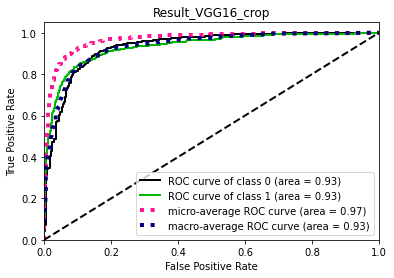

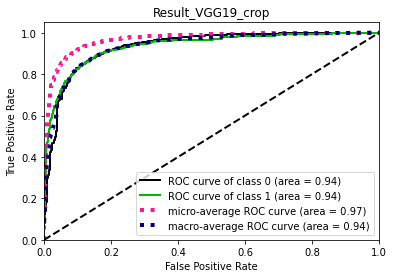

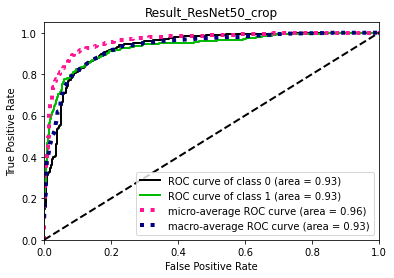

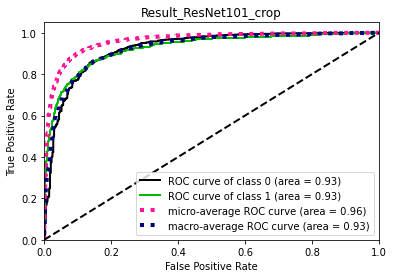

In [26]:
# skplt.metrics.plot_roc(TEST_GENERATOR.classes.tolist(), Result_EfficientNetB7, title='Result_EfficientNetB7')

skplt.metrics.plot_roc(TEST_GENERATOR.classes.tolist(), Result_VGG16_crop, title='Result_VGG16_crop')

skplt.metrics.plot_roc(TEST_GENERATOR.classes.tolist(), Result_VGG19_crop, title='Result_VGG19_crop')

skplt.metrics.plot_roc(TEST_GENERATOR.classes.tolist(), Result_ResNet50_crop, title='Result_ResNet50_crop')

skplt.metrics.plot_roc(TEST_GENERATOR.classes.tolist(), Result_ResNet101_crop, title='Result_ResNet101_crop')

Cropped된 data로 학습 후 cropped된 data로 예측을 하니 결과가 매우 좋게 나왔다.

4개믜 모델 모두 93%이상의 확률로 benign과 cancer를 구분하였고 ROC curve도 매우 잘 나왔다.

이미지를 전처리하는 것만으로 모델의 성능이 올라간다는 것을 볼 수 있는 결과였다.

## 10. Cropped된 data로 학습 후 Cropped되지 않은 data로 결과 확인하기

모델 학습은 Cropped된 data를 이용하고 test는 Cropped되지 않은 원본 data를 이용한다.

학습 과정 생략

In [27]:
# test_directory만 변경 
test_directory  = CurrentDirectory + 'TEST/'

In [30]:
# Generator의 instance 생성 (Test)
TEST_GENERATOR = DATAGEN_TEST.flow_from_directory(
    test_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = False,
    class_mode= "categorical")

Found 1166 images belonging to 2 classes.


In [31]:
# Prediction
# TEST_Prediction_EfficientNetB7_crop = DeepLearning_EfficientNetB7.predict_generator(TEST_GENERATOR, verbose=1)
TEST_Prediction_VGG16_crop = DeepLearning_VGG16.predict_generator(TEST_GENERATOR, verbose=1)
TEST_Prediction_VGG19_crop = DeepLearning_VGG19.predict_generator(TEST_GENERATOR, verbose=1)
TEST_Prediction_ResNet50_crop = DeepLearning_ResNet50.predict_generator(TEST_GENERATOR, verbose=1)
TEST_Prediction_ResNet101_crop = DeepLearning_ResNet101.predict_generator(TEST_GENERATOR, verbose=1)

C:\Users\USER\AppData\Local\Temp\ipykernel_15168\1621454988.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  TEST_Prediction_VGG16_crop = DeepLearning_VGG16.predict_generator(TEST_GENERATOR, verbose=1)
C:\Users\USER\miniforge3\envs\dl2\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\USER\miniforge3\envs\dl2\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


37/37 [==============================] - 186s 5s/step


C:\Users\USER\AppData\Local\Temp\ipykernel_15168\1621454988.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  TEST_Prediction_VGG19_crop = DeepLearning_VGG19.predict_generator(TEST_GENERATOR, verbose=1)


37/37 [==============================] - 246s 7s/step


C:\Users\USER\AppData\Local\Temp\ipykernel_15168\1621454988.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  TEST_Prediction_ResNet50_crop = DeepLearning_ResNet50.predict_generator(TEST_GENERATOR, verbose=1)


37/37 [==============================] - 102s 3s/step


C:\Users\USER\AppData\Local\Temp\ipykernel_15168\1621454988.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  TEST_Prediction_ResNet101_crop = DeepLearning_ResNet101.predict_generator(TEST_GENERATOR, verbose=1)


37/37 [==============================] - 186s 5s/step


In [33]:
# data frame으로 변환
# Result_EfficientNetB7 = pd.DataFrame(TEST_Prediction_EfficientNetB7_crop)
Result_VGG16_crop = pd.DataFrame(TEST_Prediction_VGG16_crop)
Result_VGG19_crop = pd.DataFrame(TEST_Prediction_VGG19_crop)
Result_ResNet50_crop = pd.DataFrame(TEST_Prediction_ResNet50_crop)
Result_ResNet101_crop = pd.DataFrame(TEST_Prediction_ResNet101_crop)

<AxesSubplot:title={'center':'Result_ResNet101_crop'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

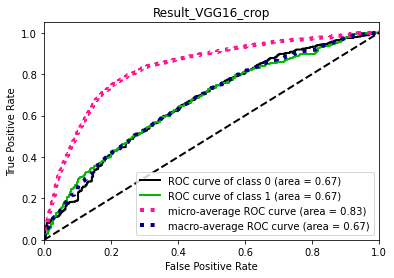

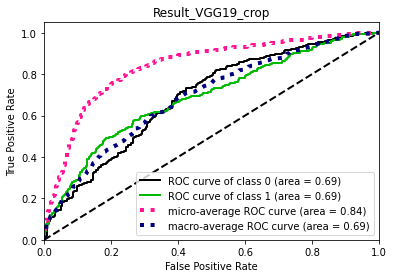

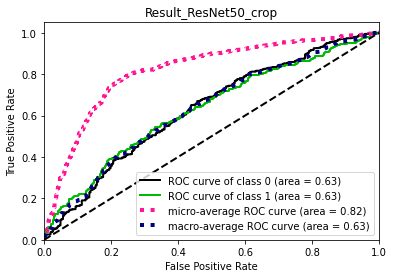

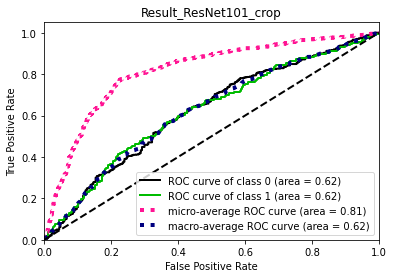

In [34]:
# skplt.metrics.plot_roc(TEST_GENERATOR.classes.tolist(), Result_EfficientNetB7, title='Result_EfficientNetB7')

skplt.metrics.plot_roc(TEST_GENERATOR.classes.tolist(), Result_VGG16_crop, title='Result_VGG16_crop')

skplt.metrics.plot_roc(TEST_GENERATOR.classes.tolist(), Result_VGG19_crop, title='Result_VGG19_crop')

skplt.metrics.plot_roc(TEST_GENERATOR.classes.tolist(), Result_ResNet50_crop, title='Result_ResNet50_crop')

skplt.metrics.plot_roc(TEST_GENERATOR.classes.tolist(), Result_ResNet101_crop, title='Result_ResNet101_crop')

결과를 보니 예측 확률이 매우 떨어졌으며 ROC도 매우 안좋게 나왔다.

VGG 모델들이 ReseNet보다 좋게 나왔지만 모두 70%도 안되는 정확도를 보인다.

강사님께서 cropped된 data로 학습을 하면 더 안좋을 것이라고 하셨는데 정말 더 안좋게 나왔다.

만약 이 모델을 실제로 쓴다고 한다면 test data를 초음파 사진 그대로 넣을 것이기에 test data와 비슷한 이미지로 학습을 해야 

모델이 예측을 더 잘하는 것이다.

이로써 다시 한번 이미지 데이터가 얼마나 중요한지를 알게 되었다.

## 11. project를 마치며

제일 아쉬운 점은 이것저것 해보지 못했다는 점이다.

모델을 학습하는데 시간이 너무 오래 걸려 다양한 변화를 주며 학습하지 못했다.

EfficientNet의 경우 구글 colab을 이용하지 않고 local 환경에서 cpu만으로 학습하면 한 epoch 당 대략 1시간 40분이 걸렸다.

다른 모델의 경우 한 epoch 당 25분 정도로 EfficientNet 보다는 짧았지만 4개의 모델을 학습시키고 비교하고자 하니 시간이 너무 오래 걸렸다.

원래는 모델의 parameter, generator 등의 parameter를 변화시켜 얼마나 차이가 나는지 알고 싶었고 최적의 parameter를 찾고자 했으나 하지 못했다.

다른 아쉬운 점은 임상 데이터를 사용하지 못했다는 점이다. 

원래 계획은 강사님께 받은 이미지 데이터와 임상 데이터를 함께 사용해 이미지만으로 학습했을 때와 임상 데이터를 함께 사용해 학습했을 때 어떤 차이가 있나 알아보려 했으나 이미지 데이터만으로 학습하기 벅차 임상 데이터를 이용하지 못했다.

FLASK를 이용해 웹페이지를 만들어 보고 싶었으나 FLASK 공부를 하는 도중 너무 어려워 포기했다.